In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

In [2]:
def scale(guess):
    weight = pyro.sample('weight', dist.Normal(guess, 1.0))
    return pyro.sample('measurement', dist.Normal(weight, 0.75))

In [3]:
conditioned_scale = pyro.condition(scale, data={'measurement': torch.tensor(9.5)})

In [8]:
conditioned_scale(9.6)

tensor(9.5000)

In [6]:
def defered_conditioned_scale(measurement, guess):
    return pyro.condition(scale, data={'measurement': measurement})(guess)

In [9]:
defered_conditioned_scale(9.6, 9.5)

9.6

In [10]:
def scale_parametrized_guide(guess):
    a = pyro.param('a', torch.tensor(guess))
    b = pyro.param('b', torch.tensor(1.))
    return pyro.sample('weight', dist.Normal(a, torch.abs(b)))

In [11]:
from torch.distributions import constraints
def scale_parametrized_guide_constrained(guess):
    a = pyro.param('a', torch.tensor(guess))
    b = pyro.param('b', torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample('weight', dist.Normal(a, b))

a= 9.677379608154297
b= 0.5557084679603577


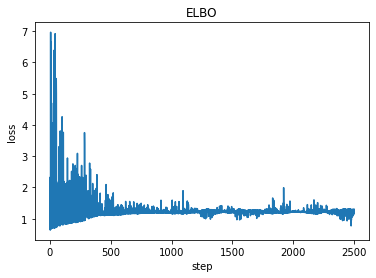

In [26]:
guess = 10.0
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale, 
                     guide=scale_parametrized_guide, 
                     optim=pyro.optim.Adam({'lr': 0.003}), 
                     loss=pyro.infer.Trace_ELBO())
losses, a, b = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param('a').item())
    b.append(pyro.param('b').item())
plt.plot(losses)
plt.title('ELBO')
plt.xlabel('step')
plt.ylabel('loss')
print('a=', pyro.param('a').item())
print('b=', pyro.param('b').item())

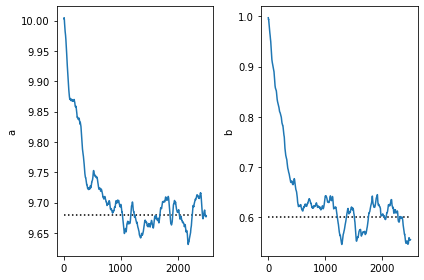

In [27]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[(0.75**2 * guess + 9.5) / (1 + 0.75**2), (0.75**2 * guess + 9.5) / (1 + 0.75**2)], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

In [14]:
conditioned_scale(8.5)

tensor(9.5000)